In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
import matplotlib.dates as mdates
from xgboost import XGBClassifier
import pickle

Alle benodigde libraries geimporteerd

In [2]:
converters = {col: lambda x: float(x.replace(',', '.')) if x != '-' else None for col in pd.read_csv('../data/datasheet.csv').columns if col != 'time'}

# Read the CSV file with converters applied
df = pd.read_csv('../data/datasheet.csv', converters=converters)

# Drop FSO_T19_SKPAuto_AanvullendeVragen omdat deze afwijkende treshold heeft
df.drop(columns=['FSO_T19_SKPAuto_AanvullendeVragen'], inplace=True)

# Replace missing values with the previous valid value
df.fillna(method='ffill', inplace=True)

# Convert 'time' column to datetime format
df['time'] = pd.to_datetime(df['time'], format='%d-%m %H:%M', errors='coerce')
current_year = pd.Timestamp.now().year
df['time'] = df['time'].apply(lambda x: x.replace(year=current_year) if not pd.isna(x) else x)


C:\Users\allar\AppData\Local\Temp\ipykernel_17676\2636241999.py:10: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


De datasheet is nu goed geconfigureerd om te gebruiken in Machine Learning

In [3]:
# Create target variables based on the threshold of 8 seconds
for col in df.columns:
    if col != 'time':
        df[f'{col}_target'] = (df[col] > 8).astype(int)

# Print the first few rows of the dataframe to check the data
print(df.head())

                 time  FSO_T00_SKPAuto_Opstarten  \
0 2025-03-12 10:00:00                       3.47   
1 2025-03-12 10:05:00                       1.84   
2 2025-03-12 10:10:00                       2.44   
3 2025-03-12 10:15:00                       4.14   
4 2025-03-12 10:20:00                       2.18   

   FSO_T01_SKPAuto_VerzekererdJaNee  FSO_T02_SKPAuto_Kenteken  \
0                              0.30                      0.27   
1                              0.71                      0.90   
2                              1.91                      3.16   
3                             15.65                      2.05   
4                              5.53                     20.05   

   FSO_T03_SKPAuto_AutoCheck  FSO_T04_SKPAuto_Postcode  \
0                       1.50                      0.30   
1                      11.43                      0.33   
2                       4.02                      3.93   
3                       3.33                      3.17   
4     

Target kolom gemaakt voor elke pagina of deze waarde boven of onder de threshold van 8 seconden zit

In [4]:
# Feature engineering: create features based on the last 10 values
window_size = 10

# Initialize empty lists for features and target variables
X = []
y = []
window_times = []  # New list to store time information
feature_names = []  # List to store feature names


# Loop through each column in the dataframe
for col in df.columns:
    if col == 'time' or '_target' in col:
        continue
        
    target_col = f'{col}_target'
    
    # Loop through the dataframe starting from the window size
    for i in range(window_size, len(df)):
        window = df[col].iloc[i-window_size:i].values
        window_time = df['time'].iloc[i]  # Get the timestamp for this window
        
        # Calculate additional features
        mean_val = np.mean(window)
        std_val = np.std(window)
        trend = np.polyfit(range(window_size), window, 1)[0]
        
        # Add hour of day as a feature
        hour_of_day = window_time.hour
        day_of_week = window_time.weekday()
        
        # Combine the features into a single array  
        combined_features = np.concatenate([window, [mean_val, std_val, trend, hour_of_day, day_of_week]])
        
        X.append(combined_features)
        y.append(df[target_col].iloc[i])
        window_times.append(window_time)  # Store the timestamp

# Convert lists to numpy arrays
X = np.array(X)
y = np.array(y)
window_times = np.array(window_times)

Window van 10 op volgorde gemeten tijden met daarbij een aantal features om te gebruiken als X waarde. hiernaast worden de zojuist gemaakte targetkolommen gebruikt als y

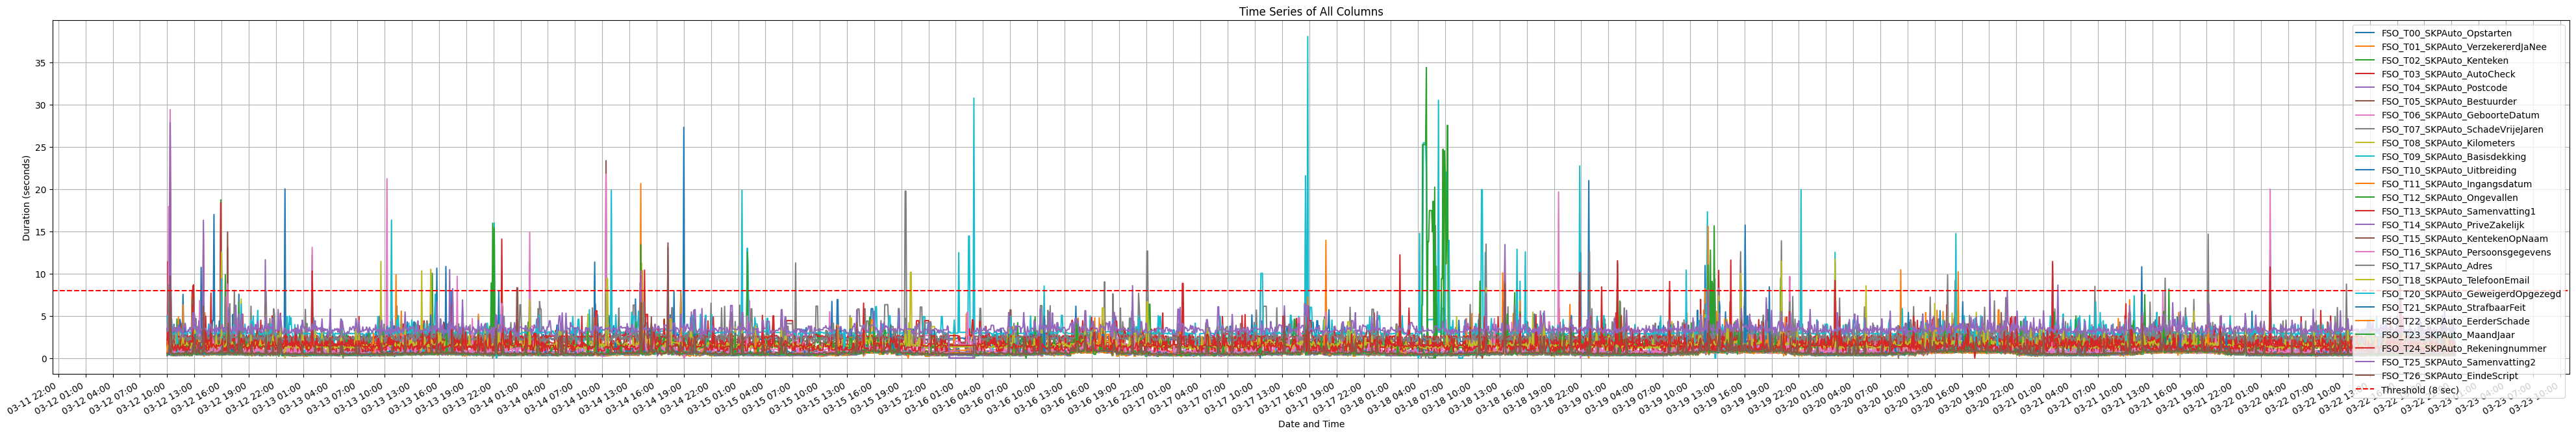

In [5]:
# Visualize the data with datetime on x-axis
plt.figure(figsize=(50, 8))
for col in df.columns:
    if col != 'time' and not col.endswith('_target'):
        plt.plot(df['time'], df[col], label=col)
plt.axhline(y=8, color='r', linestyle='--', label='Threshold (8 sec)')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=3))
plt.gcf().autofmt_xdate()  # Rotate date labels for better readability
plt.legend()
plt.xlabel('Date and Time')
plt.ylabel('Duration (seconds)')
plt.title('Time Series of All Columns')
plt.grid(True)
plt.show()

Visualisatie van de gemeten tijden met een treshhold lijn. Hierin zijn duidelijk de pieken te zien van de 'te lange' laadtijden

In [6]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=69)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# Train different models and evaluate their performance
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, class_weight='balanced'),
    'Random Forest': RandomForestClassifier(class_weight='balanced', n_estimators=100),
    'SVM': SVC(probability=True, class_weight='balanced'),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', scale_pos_weight=1)
}

results = {}

for name, model in models.items():
    # Train the model
    model.fit(X_train_scaled, y_train)
    # Make predictions
    y_pred = model.predict(X_test_scaled)
    # Evaluate the model

    accuracy = accuracy_score(y_test, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
    cm = confusion_matrix(y_test, y_pred)
    TN, FP, FN, TP = confusion_matrix(y_test, y_pred).ravel()
    binairyaccuracy =  (TP + TN) / (TP + FP + TN + FN)

    results[name] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'confusion_matrix': cm
    }
    
    print(f"\n{name} Performance:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"\n{name} Confusion Matrix:")
    print('True Positive(TP)  = ', TP)
    print('False Positive(FP) = ', FP)
    print('True Negative(TN)  = ', TN)
    print('False Negative(FN) = ', FN)
    print('Accuracy of the binary classifier= {:0.3f}'.format(binairyaccuracy))
    print(f"\n{name} Classification Report:")
    print(classification_report(y_test, y_pred))
    print("------------------------------")

# Choose the best model based on F1 score
best_model_name = max(results, key=lambda x: results[x]['f1'])
print(f"\nBest model: {best_model_name} with F1 Score: {results[best_model_name]['f1']:.4f}")



Logistic Regression Performance:
Accuracy: 0.7504
Precision: 0.0079
Recall: 0.6458
F1 Score: 0.0156

Logistic Regression Confusion Matrix:
True Positive(TP)  =  31
False Positive(FP) =  3902
True Negative(TN)  =  11754
False Negative(FN) =  17
Accuracy of the binary classifier= 0.750

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.75      0.86     15656
           1       0.01      0.65      0.02        48

    accuracy                           0.75     15704
   macro avg       0.50      0.70      0.44     15704
weighted avg       1.00      0.75      0.85     15704


Random Forest Performance:
Accuracy: 0.9970
Precision: 0.5714
Recall: 0.0833
F1 Score: 0.1455

Random Forest Confusion Matrix:
True Positive(TP)  =  4
False Positive(FP) =  3
True Negative(TN)  =  15653
False Negative(FN) =  44
Accuracy of the binary classifier= 0.997

Classification Report:
              precision    recall  f1-score   support

           0  

4 verschillende modellen gebruikt en degene met de beste resultaten van de gekozen evaluatiemodellen genoteerd

In [ ]:
# Hyperparameter tuning for the best model
if best_model_name == 'Random Forest':
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    model = RandomForestClassifier(class_weight='balanced')
elif best_model_name == 'XGBoost':
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 4, 5],
        'learning_rate': [0.01, 0.2, 0.3],
        'subsample': [0.8, 0.9, 1.0],
        'colsample_bytree': [0.8, 0.9, 1.0]
    }
    model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
elif best_model_name == 'Logistic Regression':
    param_grid = {
        'C': [0.01, 0.1, 1, 10, 100],
        'solver': ['liblinear', 'lbfgs'],
        'penalty': ['l1', 'l2']
    }
    model = LogisticRegression(max_iter=1000, class_weight='balanced')
else:  # SVM
    param_grid = {
        'C': [0.1, 1, 10, 100],
        'gamma': ['scale', 'auto', 0.1, 0.01],
        'kernel': ['rbf', 'linear', 'poly']
    }
    model = SVC(probability=True, class_weight='balanced')

# Grid search for hyperparameter tuning
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

print(f"\nBest parameters: {grid_search.best_params_}")
best_model = grid_search.best_estimator_

Beste hyperparameters zoeken aan de hand van de uitkomst van het beste model

In [ ]:
# Evaluate the tuned model
y_pred = best_model.predict(X_test_scaled)
print("\nTuned Model Performance:")
print(classification_report(y_test, y_pred))

In [ ]:
# Save the best model and scaler for later use
pickle.dump(best_model, open('best_model.pkl', 'wb'))
pickle.dump(scaler, open('scaler.pkl', 'wb'))



In [ ]:

# Function to predict if the next load time will breach the threshold of 8 seconds
def predict_threshold_breach(model, scaler, new_data, datetime, window_size=10):
    """
    Voorspel of de laadtijd boven de 8 seconden zal komen op basis van recente metingen.
    
    Parameters:
    - model: Het getrainde model
    - scaler: De feature scaler
    - new_data: Array van recente laadtijden (minimaal window_size elementen)
    - window_size: Aantal voorgaande waarden om te gebruiken voor de voorspelling
    
    Returns:
    - Waarschijnlijkheid dat de volgende waarde boven de 8 seconden komt
    """
    if len(new_data) < window_size:
        raise ValueError(f"Niet genoeg data punten. Minimaal {window_size} nodig.")
    
    # Use the latest window_size data points
    recent_data = new_data[-window_size:]

    # Calculate additional features
    mean_val = np.mean(recent_data)
    std_val = np.std(recent_data)
    trend = np.polyfit(range(window_size), recent_data, 1)[0]
    
    # Bereken alle gebruikte features
    hour_of_day = datetime.now().hour
    day_of_week = datetime.now().weekday()

    features = np.concatenate([recent_data, [mean_val, std_val, trend, hour_of_day, day_of_week]])
    features = features.reshape(1, -1)
    
    # Scale the features
    scaled_features = scaler.transform(features)
    
    # Make prediction
    probability = model.predict_proba(scaled_features)[0, 1]
    prediction = model.predict(scaled_features)[0]
    
    return probability, prediction == 1

Functie die een nieuwe voorspelling kan maken

In [ ]:
#Functie die de nieuwe csv importeert, goed convert en per kolom de voorspelling doet
new_data = pd.read_csv('../data/datasheet_new.csv', converters=converters)
new_data.drop(columns=['FSO_T19_SKPAuto_AanvullendeVragen'], inplace=True)
new_data.fillna(method='ffill', inplace=True)
new_data['time'] = pd.to_datetime(new_data['time'], format='%d-%m %H:%M', errors='coerce')
new_data['time'] = new_data['time'].apply(lambda x: x.replace(year=current_year) if not pd.isna(x) else x)
for col in df.columns:
    if col != 'time':
        new_data[f'{col}_target'] = (df[col] > 8).astype(int)
X_new = []
y_new = []
window_times_new = []  
feature_names_new = []  
for col in new_data.columns:
    if col == 'time' or '_target' in col:
        continue
        
    target_col_new = f'{col}_target'
   

# Convert lists to numpy arrays
X_new = np.array(X)
y_new = np.array(y)
window_times_new = np.array(window_times_new)

for col in new_data.columns:
    if col != 'time' and not col.endswith('_target'):
        recent_load_times = new_data[col].iloc[-window_size:].values
        datetime = new_data['time'].iloc[-1]
        prob, will_breach = predict_threshold_breach(best_model, scaler, recent_load_times, datetime)
        print(f"\nKans dat de volgende laadtijd van {col} boven 8 seconden komt: {prob:.2f}")
